In [1]:
import torch
import torchvision
#import matplotlib.pyplot as plt

# Function to split the dataset into n subsets
def split_dataset(dataset, n, sub_length):
    total_length = len(dataset)
    subset_length = total_length // sub_length
    subsets = []
    for i in range(n):
        subset = torch.utils.data.Subset(dataset, range(i * subset_length, (i + 1) * subset_length))
        subsets.append(subset)
    return subsets

# Preparing the Dataset
batch_size_train = 10 
batch_size_test = 1000
learning_rate = 0.05 
momentum = 0.5
log_interval = 10
random_seed = 1
nr_agents = 10
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

#training dataset
full_dataset = torchvision.datasets.MNIST('/files/', train=True, download=True,
                                          transform=torchvision.transforms.Compose([
                                              torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Normalize(
                                                  (0.1307,), (0.3081,))
                                          ]))
#testing dataset
test_dataset = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

# Splitting the dataset into n subsets for n agents
n_subsets = nr_agents  
sub_len = 10  #change this if want to modify the size of each agent's dataset
subset_datasets = split_dataset(full_dataset, n_subsets, sub_len)

# creating train loaders list and test loaders list
train_loaders = []
test_loaders = []

for subset_dataset in subset_datasets:
    train_loader = torch.utils.data.DataLoader(subset_dataset, batch_size=batch_size_train, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)
    train_loaders.append(train_loader)
    test_loaders.append(test_loader)


examples = enumerate(test_loaders[1])
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

print(len(train_loaders[0].dataset))

6000


C:\Users\yangr\AppData\Local\Temp\ipykernel_27568\1315194477.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\yangr\AppData\Local\Temp\ipykernel_27568\1315194477.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


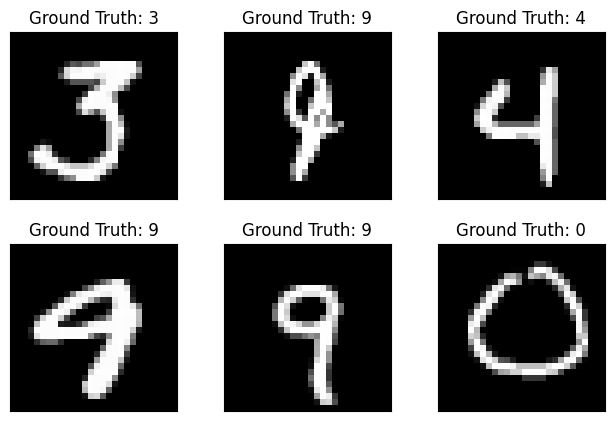

In [2]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig.show()

In [3]:
#Buidling the network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#torch.nn layers as which contain trainable parameters
#torch.nn.functional are purely functional
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    #defines the way we compute our output using the given layers and functions
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
# initialize the networks and the optimizers
# store in a list
networks = [Net() for agent in range(nr_agents)]
optimizers = [optim.SGD(networks[agent].parameters(), lr=learning_rate, momentum=momentum) for agent in range(nr_agents)]


In [4]:

#define test function to inspect accuracy
accuracy=[]

def test(agent): 
  networks[agent].eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loaders[agent]:
      output = networks[agent](data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loaders[agent].dataset)
  
  print('\nTest set{}: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    agent, test_loss, correct, len(test_loaders[agent].dataset), 100. * correct / len(test_loaders[agent].dataset)))
  accuracy.append( 100. * correct / len(test_loaders[agent].dataset))

#inital testing without training
for agent in range(nr_agents):
  test(agent)


C:\Users\yangr\AppData\Local\Temp\ipykernel_27568\138897234.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
c:\Users\yangr\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set0: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)


Test set1: Avg. loss: 2.3010, Accuracy: 1219/10000 (12%)


Test set2: Avg. loss: 2.3086, Accuracy: 989/10000 (10%)


Test set3: Avg. loss: 2.3110, Accuracy: 973/10000 (10%)


Test set4: Avg. loss: 2.3114, Accuracy: 1144/10000 (11%)


Test set5: Avg. loss: 2.3116, Accuracy: 991/10000 (10%)


Test set6: Avg. loss: 2.3363, Accuracy: 1470/10000 (15%)


Test set7: Avg. loss: 2.3081, Accuracy: 1624/10000 (16%)


Test set8: Avg. loss: 2.3125, Accuracy: 1027/10000 (10%)


Test set9: Avg. loss: 2.3097, Accuracy: 958/10000 (10%)



[[1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 1. 1. 0. 1.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]]


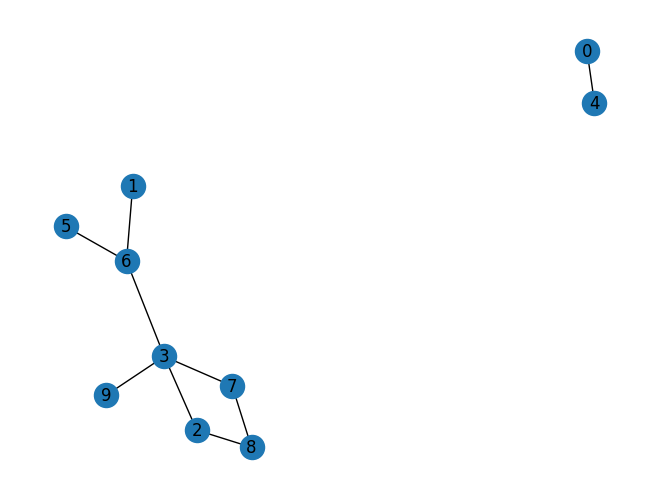

In [5]:
#define connection graph in adjacency matrix format
#can either be hard coded or generated using Erdos Renyi's graph
#each row represent each agent's connection to other agents in the network
#e.g if agent 0 connnected to agent 3: graph[0][3] = 1

import networkx as nx
connect_prob = 0.2
random_graph =nx.erdos_renyi_graph(nr_agents, connect_prob)
graph = nx.to_numpy_array(random_graph)

#each agent is connected to itself, so need to change all diagonal element to be 1
for i in range(len(graph)):
    graph[i][i]=1
print(graph)
nx.draw(random_graph, with_labels = True)
plt.show()

In [6]:
from final_pack import decentralised
import copy
#define epochs and average interval
ep = 15
avg_interval = 10

new_network = decentralised(train_loaders, networks, optimizers, graph)

for epoch in range(1, ep):

    print('epoch',epoch)
    
    while new_network.train_finish != True:
        new_network.avg_n()
        new_network.step_train(avg_interval)
        print('average break')

    networks = copy.deepcopy(new_network.model) #load back modified networks

    for agent in range(nr_agents):
        test(agent)

    new_network.train_finish = False #initialise for next epoch



epoch 1


C:\Users\yangr\AppData\Local\Temp\ipykernel_27568\138897234.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break
average break

Test set0: Avg. loss: 0.2809, Accuracy: 9342/10000 (93%)


Test set1: Avg. loss: 0.3806, Accuracy: 8769/10000 (88%)


Test set2: Avg. loss: 0.2137, Accuracy: 9

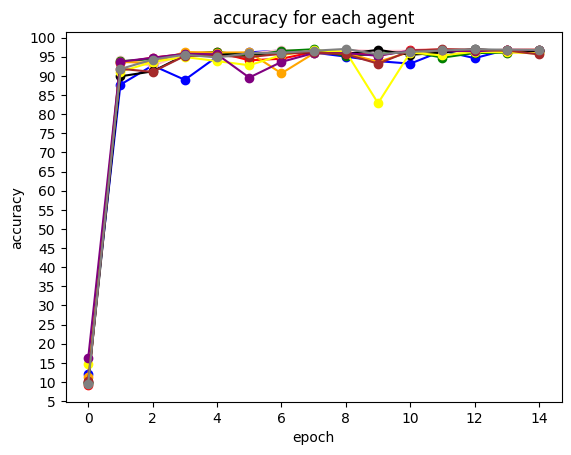

In [7]:
#visualise accuracy

import matplotlib.pyplot as plt
import numpy as np

# Some example data to display
x = [i for i in range(ep)]
y = [[1]*ep for i in range(nr_agents)] 

for e in range(ep):
    for i in range (nr_agents):
        y[i][e]=accuracy[e*nr_agents+i]

plt.title('accuracy for each agent')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.yticks(np.arange(0, 105, 5.0))
plt.plot(x, y[0], marker='o', linestyle='-', color='red')
plt.plot(x, y[1], marker='o', linestyle='-', color='blue')
plt.plot(x, y[2], marker='o', linestyle='-', color='pink')
plt.plot(x, y[3], marker='o', linestyle='-', color='green')
plt.plot(x, y[4], marker='o', linestyle='-', color='orange')
plt.plot(x, y[5], marker='o', linestyle='-', color='black')
plt.plot(x, y[6], marker='o', linestyle='-', color='yellow')
plt.plot(x, y[7], marker='o', linestyle='-', color='purple')
plt.plot(x, y[8], marker='o', linestyle='-', color='brown')
plt.plot(x, y[9], marker='o', linestyle='-', color='gray')

plt.show()